# About Dataset
Earthquake Alert Prediction Dataset

link https://www.kaggle.com/datasets/ahmeduzaki/earthquake-alert-prediction-dataset/data


Earthquake Alert Prediction DatasetA comprehensive preprocessed earthquake dataset containing 1,300 samples specifically engineered for machine learning applications in seismic hazard assessment and earthquake alert prediction systems. This dataset has been enhanced through advanced oversampling techniques using SMOTE to achieve optimal class balance, ensuring superior model training performance for earthquake alert classification tasks.

## Imports

In [38]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.7 MB/s eta 0:00:00


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import optuna
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

scorer = make_scorer(f1_score, average='weighted')

## Loading the data


In [16]:
df = pd.read_csv("earthquake_alert_balanced_dataset.csv")

In [17]:
df.head()

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


## Explore the data

In [19]:
df.isnull().sum().sum()

np.int64(0)

In [20]:
df.duplicated().sum()

np.int64(44)

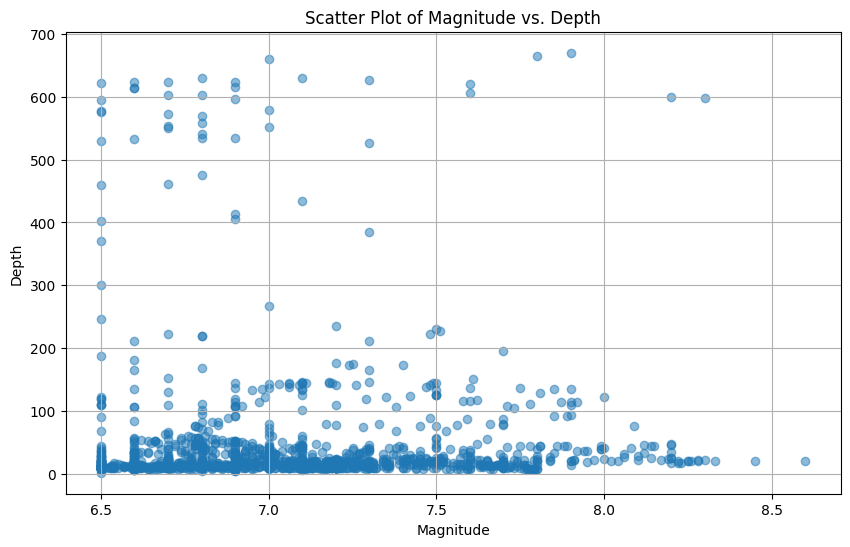

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(df['magnitude'], df['depth'], alpha=0.5)
plt.xlabel('Magnitude')
plt.ylabel('Depth')
plt.title('Scatter Plot of Magnitude vs. Depth')
plt.grid(True)
plt.show()

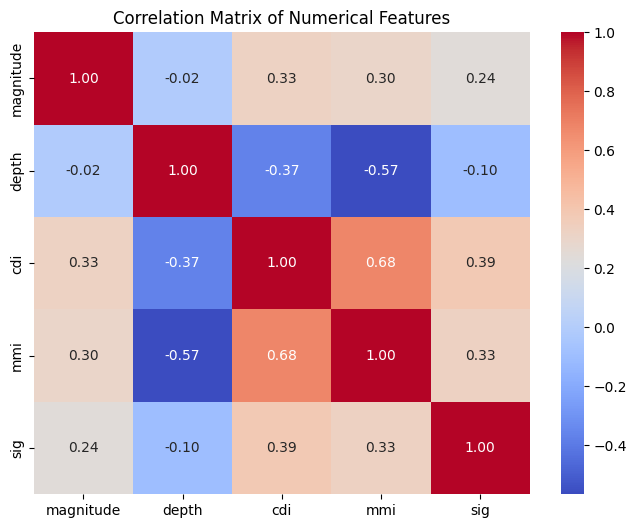

In [23]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [25]:
df.shape

(1300, 6)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1300 non-null   float64
 1   depth      1300 non-null   float64
 2   cdi        1300 non-null   float64
 3   mmi        1300 non-null   float64
 4   sig        1300 non-null   float64
 5   alert      1300 non-null   object 
dtypes: float64(5), object(1)
memory usage: 61.1+ KB


## Training and Building the model


In [28]:
X = df.drop("alert",axis=1)
y = df["alert"]

In [37]:
y.shape

(1300,)

In [32]:
lb = LabelEncoder()
y = lb.fit_transform(y)

In [40]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

## Model Building

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
                                                      X, y,
                                                      test_size=0.2,
                                                      stratify=y,
                                                      random_state=42
)

In [58]:
cv = StratifiedKFold(
        n_splits     = 5,      # ← change folds here
        shuffle      = True,
        random_state = 42
)

scorer = "f1_macro"

In [48]:
def objective_logistic(trial):
    #pick solver & penalty first
    solver  = trial.suggest_categorical( "solver",  ["liblinear", "lbfgs", "saga"] )
    penalty = trial.suggest_categorical( "penalty", ["l1", "l2", "elasticnet", "none"] )

    # prune illegal (solver, penalty) combos
    valid = {
        "liblinear": {"l1", "l2"},
        "lbfgs":     {"l2", "none"},
        "saga":      {"l1", "l2", "elasticnet", "none"},
    }
    if penalty not in valid[solver]:
        raise optuna.exceptions.TrialPruned()

    # build model: 1 param per line
    model = LogisticRegression(
        solver       = solver,
        penalty      = None if penalty == "none" else penalty,
        C            = trial.suggest_float ( "C",          1e-4, 1e3, log=True ),
        l1_ratio     = trial.suggest_float ( "l1_ratio",   0.0, 1.0 )
                          if (solver == "saga" and penalty == "elasticnet") else None,
        class_weight = trial.suggest_categorical( "class_weight", [None, "balanced"] ),
        max_iter     = 5000,
        n_jobs       = -1 if solver == "saga" else None,
        random_state = 42
    )

    return cross_val_score(
        model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1
    ).mean()


In [47]:
def objective_dt(trial):
    model = DecisionTreeClassifier(
        criterion             = trial.suggest_categorical( "criterion",            ["gini", "entropy", "log_loss"] ),
        splitter              = trial.suggest_categorical( "splitter",             ["best", "random"] ),
        max_depth             = trial.suggest_int(        "max_depth",             2, 30, 2 ),          # 2 → 30, step 2
        min_samples_split     = trial.suggest_int(        "min_samples_split",     2, 40, 2 ),          # 2 → 40, step 2
        min_samples_leaf      = trial.suggest_int(        "min_samples_leaf",      1, 30 ),             # 1 → 30
        max_features          = trial.suggest_categorical( "max_features",         [None, "sqrt", "log2"] ),
        min_impurity_decrease = trial.suggest_float(      "min_impurity_decrease", 0.0, 0.01 ),
        ccp_alpha             = trial.suggest_float(      "ccp_alpha",             0.0, 0.05 ),
        class_weight          = trial.suggest_categorical( "class_weight",         [None, "balanced"] ),
        random_state          = 42
    )
    return cross_val_score(model, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1).mean()


In [49]:
#  Random Forest
def objective_rf(trial):
    model = RandomForestClassifier(
        n_estimators      = trial.suggest_int   ("n_estimators",      100, 800),
        max_depth         = trial.suggest_int   ("max_depth",         2, 30, 2),
        min_samples_split = trial.suggest_int   ("min_samples_split", 2, 40, 2),
        min_samples_leaf  = trial.suggest_int   ("min_samples_leaf",  1, 30),
        max_features      = trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        bootstrap         = trial.suggest_categorical("bootstrap",    [True, False]),
        class_weight      = trial.suggest_categorical("class_weight", [None, "balanced"]),
        random_state      = 42,
        n_jobs            = -1
    )
    return cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1).mean()


In [50]:
#  XGBoost
def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators     = trial.suggest_int  ("n_estimators",     100, 800),
        max_depth        = trial.suggest_int  ("max_depth",        2, 12),
        learning_rate    = trial.suggest_float("learning_rate",    1e-3, 0.3, log=True),
        subsample        = trial.suggest_float("subsample",        0.5, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0),
        gamma            = trial.suggest_float("gamma",            0.0, 5.0),
        reg_alpha        = trial.suggest_float("reg_alpha",        0.0, 10.0),
        reg_lambda       = trial.suggest_float("reg_lambda",       0.0, 10.0),
        tree_method      = "hist",
        eval_metric      = "mlogloss",
        use_label_encoder= False,
        random_state     = 42,
        n_jobs           = -1
    )
    return cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1).mean()


In [51]:
# LGB
def objective_lgb(trial):
    model = LGBMClassifier(
        n_estimators     = trial.suggest_int  ("n_estimators",     100, 1000),
        max_depth        = trial.suggest_int  ("max_depth",        -1, 30),
        num_leaves       = trial.suggest_int  ("num_leaves",       15, 255),
        learning_rate    = trial.suggest_float("learning_rate",    1e-3, 0.3, log=True),
        subsample        = trial.suggest_float("subsample",        0.5, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0),
        reg_alpha        = trial.suggest_float("reg_alpha",        0.0, 10.0),
        reg_lambda       = trial.suggest_float("reg_lambda",       0.0, 10.0),
        class_weight     = trial.suggest_categorical("class_weight", [None, "balanced"]),
        random_state     = 42,
        n_jobs           = -1,
        verbose          = -1
    )
    return cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1).mean()

In [52]:
def run_study(name, objective, trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials, show_progress_bar=False)
    print(f" Best {name} Params:", study.best_params)
    print(f" Best {name} F1 Score:", study.best_value)
    return study.best_params

## All model results

In [53]:
best_lr = run_study("Logistic Regression", objective_logistic, 60)
best_dt = run_study("Decision Tree", objective_dt, 60)
best_rf = run_study("Random Forest", objective_rf, 60)
best_xgb = run_study("XGBoost", objective_xgb, 60)
best_lgb = run_study("LightGBM", objective_lgb, 60)

 Best Logistic Regression Params: {'solver': 'saga', 'penalty': 'l2', 'C': 5.427494587622356, 'class_weight': 'balanced'}
 Best Logistic Regression F1 Score: 0.635454860647111
 Best Decision Tree Params: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'min_impurity_decrease': 0.008770357685435446, 'ccp_alpha': 0.0003598911903014534, 'class_weight': None}
 Best Decision Tree F1 Score: 0.8108505677016807
 Best Random Forest Params: {'n_estimators': 236, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}
 Best Random Forest F1 Score: 0.8955698888458455
 Best XGBoost Params: {'n_estimators': 252, 'max_depth': 11, 'learning_rate': 0.1922368182722269, 'subsample': 0.6884696843611036, 'colsample_bytree': 0.9184993972863076, 'gamma': 0.20891886460068382, 'reg_alpha': 0.8004834326874792, 'reg_lambda': 6.232278027336061}
 Best XGBoost F1

## Ensemble Models

In [63]:
lr_clf = LogisticRegression(
    solver=best_lr["solver"],
    penalty=None if best_lr.get("penalty")=="none" else best_lr.get("penalty"),
    C=best_lr["C"],
    l1_ratio=best_lr.get("l1_ratio", None),
    max_iter=5000,
    random_state=42
)

dt_clf = DecisionTreeClassifier(**best_dt, random_state=42)
rf_clf = RandomForestClassifier(**best_rf, random_state=42)
xgb_clf = XGBClassifier(**best_xgb, eval_metric="mlogloss", use_label_encoder=False, random_state=42)
lgb_clf = LGBMClassifier(**best_lgb, random_state=42)

In [64]:
voting = VotingClassifier(
    estimators=[("lr", lr_clf), ("dt", dt_clf), ("rf", rf_clf), ("xgb", xgb_clf), ("lgb", lgb_clf)],
    voting="soft"
)
voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 5
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [65]:
stacking = StackingClassifier(
    estimators=[("lr", lr_clf), ("dt", dt_clf), ("rf", rf_clf), ("xgb", xgb_clf), ("lgb", lgb_clf)],
    final_estimator=SVC(probability=True, random_state=42),
    cv=3
)
stacking.fit(X_train, y_train)
y_pred_stacking = stacking.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 5
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

## Voting and stacking results

In [67]:
print("\n✅ Voting Classifier F1 Score:", f1_score(y_test, y_pred_voting, average="weighted"))


✅ Voting Classifier F1 Score: 0.9310817220779306


In [66]:
print("✅ Stacking Classifier F1 Score:", f1_score(y_test, y_pred_stacking, average="weighted"))

✅ Stacking Classifier F1 Score: 0.927182016905553
